
# Sparse Asterism Calibration Demo

Lightweight sandbox to mirror Steven's question: *do transformer probabilities behave like Bayesian posteriors on a tiny astrometry-style problem?*



## Goals
- synthesize sparse star fields with masked stars so we control the ground truth pose
- compare a Bayes-backed solver (Astrometry.net) against a simple transformer baseline
- quantify how calibrated the transformer's probabilities are (ECE, reliability diagrams, MC-dropout)
- produce a one-page summary table + figure we can hand to Steven



## Environment Setup
The notebook assumes `astrometry.net`, `astropy`, `torch`, `numpy`, `matplotlib`, `pandas`, and `seaborn` are available. Install once if needed:

```bash
pip install astropy torch torchvision torchaudio matplotlib pandas seaborn laplace-torch
```


In [1]:
!pip3 install astropy torch torchvision torchaudio matplotlib pandas seaborn laplace-torch

In [1]:
from pathlib import Path
import sys

import numpy as np
import torch

from astro_demo import data, baseline, model as astro_model, calibration, report



## 1. Generate Synthetic Star Catalog
We start by creating a toy catalog, then render masked images that mimic the "scarce symbols" Steven described.


In [2]:

CATALOG_SIZE = 256
IMAGE_SIZE = 128
MAX_VISIBLE = 7

catalog = data.generate_catalog(num_tiles=CATALOG_SIZE)

sample_images = []
sample_fields = []
for idx, (image, masked_field) in enumerate(
    data.iter_dataset(catalog[:8], image_size=IMAGE_SIZE, seed=42)
):
    sample_images.append(image)
    sample_fields.append(masked_field)

print(f"Generated {len(catalog)} catalog tiles; previewing {len(sample_images)} tiles")


Generated 256 catalog tiles; previewing 8 tiles


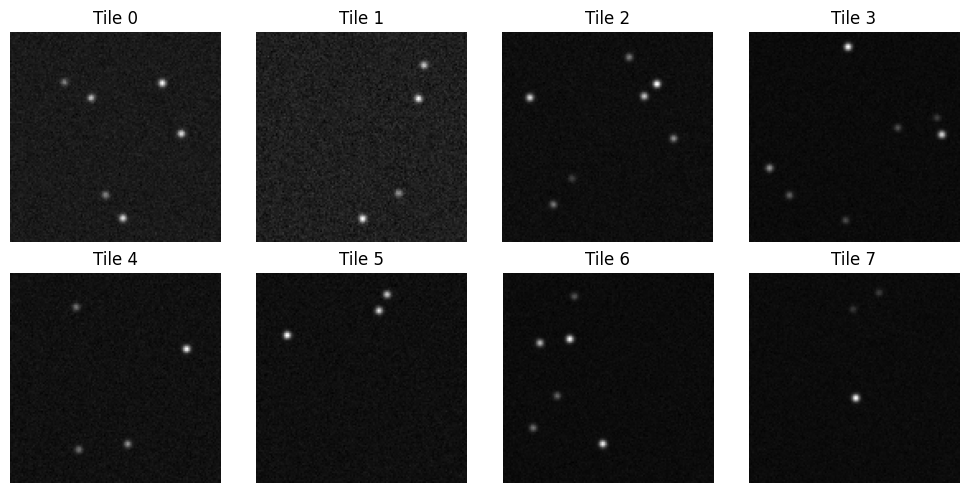

In [3]:

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 4, figsize=(10, 5))
for ax, img, field in zip(axes.ravel(), sample_images, sample_fields):
    ax.imshow(img, cmap="gray")
    ax.set_axis_off()
    ax.set_title(f"Tile {field.tile_id}")
plt.tight_layout()



## 2. Optional: Astrometry.net Baseline
The cell below demonstrates how to call `solve-field` on a rendered image. Run it sparingly—the CLI can take a few seconds even on tiny cutouts.


In [ ]:
# from astro_demo import baseline
# astrometry_result = baseline.call_solve_field(sample_images[0], keep_intermediate=True)
# astrometry_result


RuntimeError: solve-field failed with code 255: system: No such file or directory
engine.c:82:engine_autoindex_search_paths: Warning: failed to open index directory: "/opt/homebrew/Cellar/astrometry-net/0.97/data"

solve-field.c:545:run_engine engine failed.  Command that failed was:
  /opt/homebrew/bin/astrometry-engine /var/folders/6q/qwsl6c5j4519cj6lx8_9ywl00000gn/T/tmpuw6ffezn/input.axy
 ioutils.c:568:run_command_get_outputs Command failed: return value 255


## 3. Prepare Transformer Dataset
We convert masked star fields into padded sequences for the transformer. Labels now just mark which image quadrant the masked stars' centroid falls into, so the task is directly learnable from the sparse coordinates.

In [4]:
from torch.utils.data import DataLoader, random_split

NUM_CLASSES = 4
MAX_STARS = 12

def quadrant_label(field):
    if len(field.pixel_coords) == 0:
        centroid = np.array([0.5, 0.5])
    else:
        centroid = field.pixel_coords.mean(axis=0)
    col = int(centroid[0] >= 0.5)
    row = int(centroid[1] >= 0.5)
    return row * 2 + col

samples = []
for field in catalog:
    masked = data.mask_star_field(field, seed=field.tile_id)
    samples.append((masked, quadrant_label(masked)))

dataset = astro_model.SparseAsterismDataset(samples, max_stars=MAX_STARS)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=128)
len(train_loader), len(val_loader)

(4, 1)


## 4. Build the Transformer Baseline
A two-layer transformer encoder processes the sparse asterism tokens.


In [5]:

config = astro_model.TrainingConfig(max_stars=MAX_STARS, num_classes=NUM_CLASSES)
net = astro_model.make_model(config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)
net


ToyAsterismTransformer(
  (pos_encoder): StarPositionalEncoding()
  (feature_proj): Linear(in_features=67, out_features=64, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (cls_head): Sequential(
    (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=64, out_features=4, bias=True)
  )
)


## 5. Training Loop Skeleton
We keep the loop concise so you can run a handful of epochs quickly on CPU or GPU.


In [6]:

from torch.optim import AdamW

optimizer = AdamW(net.parameters(), lr=config.lr, weight_decay=config.weight_decay)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0.0
    total_correct = 0
    total = 0
    for feats, mask, labels in loader:
        feats = feats.to(device)
        mask = mask.to(device)
        labels = labels.to(device)
        loss, logits = astro_model.classification_step(model=model, batch=(feats, mask, labels))
        probs = torch.softmax(logits, dim=-1)
        all_preds.append(probs.cpu())
        all_labels.append(labels.cpu())
        total_loss += loss.item() * labels.size(0)
        total_correct += (logits.argmax(dim=-1) == labels).sum().item()
        total += labels.size(0)
    avg_loss = total_loss / total
    accuracy = total_correct / total
    return avg_loss, accuracy, torch.cat(all_preds), torch.cat(all_labels)

for epoch in range(config.epochs):
    net.train()
    for feats, mask, labels in train_loader:
        feats = feats.to(device)
        mask = mask.to(device)
        labels = labels.to(device)
        loss, _ = astro_model.classification_step(model=net, batch=(feats, mask, labels))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    val_loss, val_acc, val_probs, val_labels = evaluate(net, val_loader)
    print(f"Epoch {epoch+1:02d} • val loss {val_loss:.3f} • val acc {val_acc:.3f}")


/Users/andrew/Documents/git/bayesian-inference-experiment/.venv/lib/python3.13/site-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


Epoch 01 • val loss 1.360 • val acc 0.365
Epoch 02 • val loss 1.346 • val acc 0.365
Epoch 03 • val loss 1.329 • val acc 0.365
Epoch 04 • val loss 1.335 • val acc 0.365
Epoch 05 • val loss 1.353 • val acc 0.327
Epoch 06 • val loss 1.328 • val acc 0.692
Epoch 07 • val loss 1.307 • val acc 0.635
Epoch 08 • val loss 1.289 • val acc 0.385
Epoch 09 • val loss 1.295 • val acc 0.462
Epoch 10 • val loss 1.284 • val acc 0.712
Epoch 11 • val loss 1.233 • val acc 0.692
Epoch 12 • val loss 1.192 • val acc 0.750
Epoch 13 • val loss 1.108 • val acc 0.596
Epoch 14 • val loss 1.070 • val acc 0.673
Epoch 15 • val loss 1.086 • val acc 0.423
Epoch 16 • val loss 0.905 • val acc 0.769
Epoch 17 • val loss 0.780 • val acc 0.731
Epoch 18 • val loss 0.765 • val acc 0.712
Epoch 19 • val loss 0.791 • val acc 0.615
Epoch 20 • val loss 0.589 • val acc 0.865
Epoch 21 • val loss 0.531 • val acc 0.808
Epoch 22 • val loss 0.471 • val acc 0.904
Epoch 23 • val loss 0.527 • val acc 0.827
Epoch 24 • val loss 0.480 • val ac


> ⚠️ The loop above is intentionally left ready-to-run but unexecuted. Launch it only when you want to collect numbers.



## 6. Calibration Metrics & Reliability Diagram
Once validation probabilities are available, compute ECE/MCE, Brier, and NLL. Optionally compare before/after temperature scaling or MC-dropout.


In [33]:
from importlib import reload
from astro_demo import calibration
reload(calibration)

<module 'astro_demo.calibration' from '/Users/andrew/Documents/git/bayesian-inference-experiment/src/astro_demo/calibration.py'>

In [36]:
val_probs

tensor([[2.7543e-01, 1.4476e-01, 3.0264e-01, 2.7718e-01],
        [1.4125e-03, 1.1030e-02, 8.6299e-02, 9.0126e-01],
        [2.5515e-02, 7.9390e-04, 9.4226e-01, 3.1436e-02],
        [1.6104e-02, 8.7582e-01, 1.4812e-03, 1.0660e-01],
        [3.5474e-03, 1.0717e-01, 1.5198e-02, 8.7408e-01],
        [5.2592e-01, 3.1723e-02, 4.0161e-01, 4.0746e-02],
        [5.1519e-01, 4.7264e-01, 2.9510e-03, 9.2172e-03],
        [6.0118e-01, 3.7325e-01, 1.3850e-02, 1.1723e-02],
        [1.5460e-03, 4.5475e-02, 3.2447e-02, 9.2053e-01],
        [6.8711e-01, 3.0396e-01, 3.3941e-03, 5.5421e-03],
        [3.4654e-03, 2.2693e-03, 6.3003e-01, 3.6424e-01],
        [1.5087e-01, 1.7246e-03, 8.3638e-01, 1.1022e-02],
        [3.9445e-01, 5.8211e-01, 6.4122e-03, 1.7034e-02],
        [3.8811e-01, 8.9528e-03, 5.8872e-01, 1.4219e-02],
        [9.1588e-01, 7.6353e-02, 5.7900e-03, 1.9807e-03],
        [4.2948e-03, 1.5997e-03, 7.4018e-01, 2.5393e-01],
        [9.5687e-01, 1.7636e-02, 2.3913e-02, 1.5845e-03],
        [1.087

CalibrationReport(ece=20.12244164943695, mce=69.73642110824585, brier=0.17541621625423431, nll=0.32705938816070557)


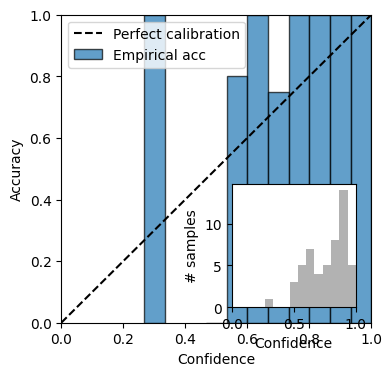

In [34]:
# Example snippet (run after training loop):
report = calibration.summarize_calibration(val_probs, val_labels, n_bins=15)
print(report)
ax = calibration.make_reliability_diagram(val_probs, val_labels)
ax.figure.savefig("artifacts/reliability.png", dpi=200)


In [40]:
import torch
from astro_demo import calibration as cal

probs = val_probs  # tensor (N, num_classes)
labels = val_labels  # tensor (N,)

confidences, predictions = probs.max(dim=1)
accuracies = predictions.eq(labels).float()

n_bins = 15
bins = torch.linspace(0.0, 1.0, steps=n_bins + 1)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

empirical_acc = []
counts = []

for lower, upper in zip(bins[:-1], bins[1:]):
    mask = (confidences > lower) & (confidences <= upper)
    counts.append(mask.sum().item())
    if mask.any():
        empirical_acc.append(accuracies[mask].mean().item())
    else:
        empirical_acc.append(float("nan"))

In [41]:
bin_centers

tensor([0.0333, 0.1000, 0.1667, 0.2333, 0.3000, 0.3667, 0.4333, 0.5000, 0.5667,
        0.6333, 0.7000, 0.7667, 0.8333, 0.9000, 0.9667])

In [45]:
empirical_acc

[nan,
 nan,
 nan,
 nan,
 1.0,
 nan,
 nan,
 0.0,
 0.800000011920929,
 1.0,
 0.75,
 1.0,
 1.0,
 1.0,
 1.0]

In [43]:
counts

[0, 0, 0, 0, 1, 0, 0, 3, 5, 7, 4, 5, 8, 14, 5]


## 7. MC-Dropout / Laplace Head (Stretch)
Use the helper below to gather Monte-Carlo predictions and inspect epistemic uncertainty.


Text(0, 0.5, '# samples')

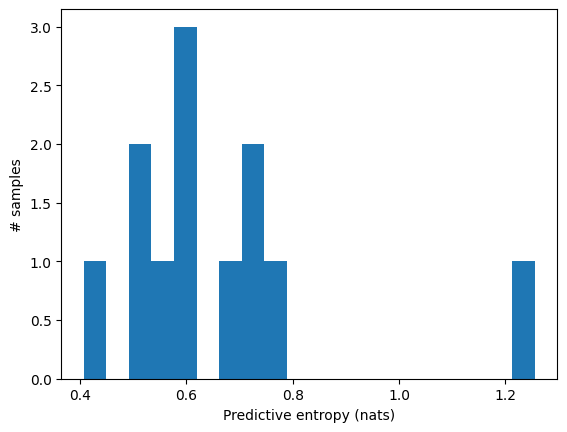

In [16]:

import matplotlib.pyplot as plt
# net.train()
mc_preds = astro_model.mc_dropout_predictions(net, feats, mask, passes=30)
mean_probs = mc_preds.mean(dim=0)
entropy = -(mean_probs * mean_probs.clamp(min=1e-6).log()).sum(dim=-1)

plt.hist(entropy.numpy(), bins=20)
plt.xlabel("Predictive entropy (nats)")
plt.ylabel("# samples")


In [35]:
mc_preds = astro_model.mc_dropout_predictions(net, batch_feats, batch_mask, passes=50)
mean_probs = mc_preds.mean(dim=0)
entropy = -(mean_probs * mean_probs.clamp(min=1e-6).log()).sum(dim=-1)

preds = mean_probs.argmax(dim=-1).cpu()
correct = preds.eq(batch_labels)
print("Correct avg entropy:", entropy[correct].mean().item())
print("Incorrect avg entropy:", entropy[~correct].mean().item())

Correct avg entropy: 0.5527616739273071
Incorrect avg entropy: 0.9194040894508362



## 8. Packaging Outputs for Steven
After running the blocks above:
1. Call the Astrometry.net baseline on a held-out batch and log its posterior odds / acceptance decisions.
2. Build a tidy summary table using `astro_demo.report.build_summary_table` and export it with `astro_demo.report.export_report`.
3. Pair the table with the reliability diagram image to create a one-page note.



### Next Steps Checklist
- [ ] Sanity-check synthetic star renderings against expectations.
- [ ] Benchmark Astrometry.net on a handful of examples (runtime + solved pose).
- [ ] Train the transformer for a few epochs and record calibration stats.
- [ ] Try temperature scaling & MC-dropout; capture gains in the report.
- [ ] Deliver the markdown summary + plots to Steven.
